# Plotter 2d

A class for creating quick 2d line plots with similar to the plot functionality of graphing calculators

In [1]:
import sys
import numpy as np
import math
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import ipywidgets as widgets
import sympy as sym
from IPython.display import display
sys.path.append("../")

%load_ext autoreload
%autoreload 2
%matplotlib widget
  
def run_fun(xs,fun, **variables):
    result = []
    for v in xs:
        try:
            result.append(fun(v,**variables))
        except:
            # Deal with undefined
            result.append(None)
    return result
    
class FunPlot2d:
    
    def __init__(
            self, 
            title="",
            funs={},
            variables = {},
            variable_options = {},
            xmin = 0,
            xmax = 10,
            ymin = 0,
            ymax = 10):
        
        self.title=title
        self.fig, self.ax = plt.subplots( figsize=(6, 4))
        # self.fig.canvas.toolbar_visible = False
        # self.fig.canvas.header_visible = False
        self.fig.canvas.resizable = True

        self.ax.grid(True)
        self.funs = funs
        self.variables = variables
        self.variable_options = variable_options 
        
        self.update_x=True
        self.xmin = xmin
        xstep = abs(xmax-xmin)/100
        self.xmin_options = (xmin,xmax,xstep)
        self.xmax = xmax
        self.xmax_options = (xmin,xmax,xstep)
        self.xstep = xstep
        self.xstep_options = (xstep/10,xstep*10,0.1)
        self.xs = np.arange(self.xmin, self.xmax,self.xstep)
        
        ystep = (ymax-ymin)/100
        self.ymin = ymin
        self.ymin_options = (ymin,ymax,ystep)
        self.ymax = ymax
        self.ymax_options = (ymin,ymax,ystep)
        self.autoscale = True
        
        self.y_data = {}
        self.rendering=False
       
    def reset(self):
        self.funs = {}
        self.variables = {}
        self.variables_options = {}
        if self.rendering:
            self.call()
            self.redraw()
            
    def set_variables(self,values,options):
        self.variables = values
        self.variable_options = options
        if self.rendering:
            self.call()
            self.redraw()

    def set_xrange(self,xmin,xmax,xstep=None):
        self.update_x = True
        if xstep is None:
            xstep = abs(xmax-xmin)/100
        self.xmin = xmin
        self.xmin_options = (xmin,xmax,xstep)
        self.xmax = xmax
        self.xmax_options = (xmin,xmax,xstep)
        self.xstep = xstep
        xstepstep = abs(xstep*100 - xstep)/50
        self.xstep_options = (xstep,xstep*100,xstepstep)
        if self.rendering:
            self.call()
            self.redraw()

    def set_yrange(self,ymin,ymax,ystep=None):
        if ystep is None:
            ystep = (ymax-ymin)/100
        self.ymin = ymin
        self.ymin_options = (ymin,ymax,ystep)
        self.ymax = ymax
        self.ymax_options = (ymin,ymax,ystep)
        self.autoscale=False
        if self.rendering:
            self.call()
            self.redraw()
        
    def add_function(self,label,fun,color=None):
        if color is None:
            color = f"C{len(self.funs)}"
        
        self.funs[label] ={
            'fun':fun,
            'color':color
        }
        if self.rendering:
            self.call()
            self.redraw()
    
    def add_sym_fun(self,funst,label=None,color=None):
        funst = str(funst)
        import math
        import numpy as np
        def fun(x,**kwargs): 
            kwargs['x'] = x
            kwargs['math'] = math
            kwargs['sym'] = sym
            kwargs['np'] = np
            return eval(funst,kwargs)
        if label is None:
            label = funst
        self.add_function(label,fun,color)

    def call(self):
        for label,item in self.funs.items():
            try:
                self.y_data[label] = run_fun(self.xs,item['fun'], **self.variables) 
            except Exception as e:
                self.y_data[label] = [0 for x in self.xs]
                print(e)
    
    def redraw(self):

        while len(self.ax.lines) >0:
            [l.remove() for l in self.ax.lines]
        self.ax.ignore_existing_data_limits = True
        # self.ax.update_datalim(scatter.get_datalim(self.ax.transData))
        self.ax.autoscale_view()
        self.ax.set_title(self.title)
        self.fig.canvas.draw_idle()
        if self.update_x:
            self.xs = np.arange(self.xmin, self.xmax,self.xstep)
            self.call()
            self.update_x = False
        if not self.autoscale:
            if self.ymin < self.ymax:
                self.ax.set_ylim([self.ymin, self.ymax])
            if self.xmin < self.xmax:
                self.ax.set_xlim([self.xmin, self.xmax])
        else:
            self.ax.relim()
            self.ax.autoscale()
            # Data lim
            # plot.ax.dataLim.x1
        lines = []
        labels = []
        for label,item in self.funs.items():
            line, = self.ax.plot(self.xs, self.y_data[label],color=item['color'])
            lines.append(line)
            labels.append(f"{label}")
        self.ax.legend(lines,labels)
        
        self.fig.canvas.draw()

    def update_y_axis(self,ymin,ymax,autoscale):
        self.ymin =  ymin
        self.ymax =  ymax
        self.autoscale =  autoscale
        self.redraw()

    def update_x_axis(self,xmin,xmax,xstep):
        if xmin < xmax:
            self.xmin =  xmin
            self.xmax =  xmax
        if xstep>0:
            self.xstep =  xstep
        self.update_x = True
        self.redraw()

    def update_function(self,**variables):
        self.variables = variables
        self.call()
        self.redraw()
        
    def to_dataframe(self):
        data = {}
        data["x"]=list(self.xs)
        for k,v in self.y_data.items():
            data[f"{k}_y"] = v
        return pd.DataFrame(data)

    def render(self):
        if len(self.variable_options)>0:
            display(widgets.Label("Function Variables"))
            sliders = {}
            for v,val in self.variables.items():
                val_options = self.variable_options[v]
                slider = widgets.FloatSlider(value=val, min=val_options[0], max=val_options[1],step=val_options[2])
                sliders[v] = slider                
            widgets.interact(self.update_function, **sliders)
        
        
        display(widgets.Label("X and Y Bounding boxes"))
        xminslider = widgets.FloatSlider(value=self.xmin, min=self.xmin_options[0], max=self.xmin_options[1],step=self.xmin_options[2])
        xmaxslider = widgets.FloatSlider(value=self.xmax, min=self.xmax_options[0], max=self.xmax_options[1],step=self.xmax_options[2])
        xstepslider = widgets.FloatSlider(value=self.xstep, min=self.xstep_options[0], max=self.xstep_options[1],step=self.xstep_options[2])
        widgets.interact(
            self.update_x_axis,
            xmin=xminslider,
            xmax=xmaxslider,
            xstep=xstepslider)

        
        yminslider = widgets.FloatSlider(value=self.ymin, min=self.ymin_options[0], max=self.ymin_options[1],step=self.ymin_options[2])
        ymaxslider = widgets.FloatSlider(value=self.ymax, min=self.ymax_options[0], max=self.ymax_options[1],step=self.ymax_options[2])
        autoscalecb = widgets.Checkbox(value=False,description='Enable Auto Scale', disabled=False,indent=True)
        
        widgets.interact(
            self.update_y_axis, 
            ymin=yminslider,
            ymax=ymaxslider,
            autoscale=autoscalecb)
        self.rendering=True

# Example 1
plot a simple function

Label(value='Function Variables')

interactive(children=(FloatSlider(value=1.0, description='c', max=4.0, min=-4.0, step=0.2), Output()), _dom_cl…

Label(value='X and Y Bounding boxes')

interactive(children=(FloatSlider(value=-10.0, description='xmin', max=10.0, min=-10.0, step=0.2), FloatSlider…

interactive(children=(FloatSlider(value=-10.0, description='ymin', max=30.0, min=-10.0, step=0.4), FloatSlider…

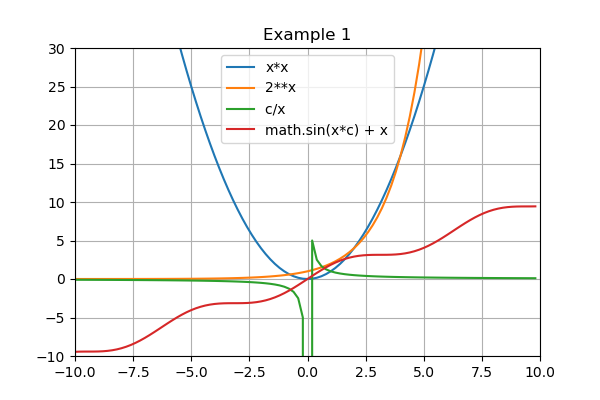

In [2]:
plot = FunPlot2d(title="Example 1")
plot.reset()
plot.set_xrange(-10,10)
plot.set_yrange(-10,30)
plot.set_variables({'c':1}, {'c':(-4,4,.2)})
plot.add_sym_fun("x*x")
plot.add_sym_fun("2**x")
plot.add_sym_fun("c/x ")
plot.add_sym_fun("math.sin(x*c) + x")
plot.render()

In [3]:
plot.to_dataframe()[:30]

,x,x*x_y,2**x_y,c/x _y,math.sin(x*c) + x_y
0,-10.0,100.00,0.000977,-0.100000,-9.455979
1,-9.8,96.04,0.001122,-0.102041,-9.433521
2,-9.6,92.16,0.001289,-0.104167,-9.425673
3,-9.4,88.36,0.001480,-0.106383,-9.424775
4,-9.2,84.64,0.001700,-0.108696,-9.422890
5,-9.0,81.00,0.001953,-0.111111,-9.412118
6,-8.8,77.44,0.002244,-0.113636,-9.384917
7,-8.6,73.96,0.002577,-0.116279,-9.334397
8,-8.4,70.56,0.002960,-0.119048,-9.254599
9,-8.2,67.24,0.003401,-0.121951,-9.140731


## Example 2
Plot Taylor series expansion

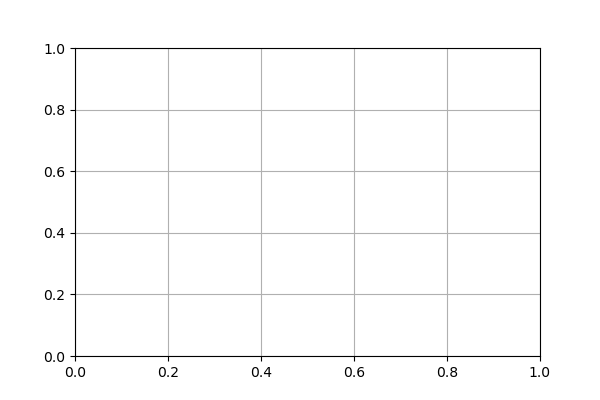

In [7]:
plot = FunPlot2d(title="Taylor polynomials for $\ln\,x$ ")
plot.reset()
plot.set_xrange(-3,10,0.01)
plot.set_yrange(-10,60,0.01)
plot.set_variables({'c':1}, {'c':(1,4,1)})

In [5]:
plot.add_sym_fun("math.log(x)",label="ln(x)")
f_next = "sym.ln(c)"
fs = [f_next]
sym_fun = "math.log(c)"

c = sym.Symbol('c')

# Build Taylor Polynomials
for i in range(6):
    f_next = str(sym.diff(eval(fs[i])))
    fs.append(f_next)
    syn_fun_part = f"(({f_next}) * ( x - c)**{i+1})/math.factorial({i+1})"
    sym_fun = f"{sym_fun} + {syn_fun_part}"
    
    print(f"P{i+1}: ",sym_fun)
    plot.add_sym_fun(sym_fun,f"$P_{i+1}$")
plot.render()

P1:  math.log(c) + ((1/c) * ( x - c)**1)/math.factorial(1)
P2:  math.log(c) + ((1/c) * ( x - c)**1)/math.factorial(1) + ((-1/c**2) * ( x - c)**2)/math.factorial(2)
P3:  math.log(c) + ((1/c) * ( x - c)**1)/math.factorial(1) + ((-1/c**2) * ( x - c)**2)/math.factorial(2) + ((2/c**3) * ( x - c)**3)/math.factorial(3)
P4:  math.log(c) + ((1/c) * ( x - c)**1)/math.factorial(1) + ((-1/c**2) * ( x - c)**2)/math.factorial(2) + ((2/c**3) * ( x - c)**3)/math.factorial(3) + ((-6/c**4) * ( x - c)**4)/math.factorial(4)
P5:  math.log(c) + ((1/c) * ( x - c)**1)/math.factorial(1) + ((-1/c**2) * ( x - c)**2)/math.factorial(2) + ((2/c**3) * ( x - c)**3)/math.factorial(3) + ((-6/c**4) * ( x - c)**4)/math.factorial(4) + ((24/c**5) * ( x - c)**5)/math.factorial(5)
P6:  math.log(c) + ((1/c) * ( x - c)**1)/math.factorial(1) + ((-1/c**2) * ( x - c)**2)/math.factorial(2) + ((2/c**3) * ( x - c)**3)/math.factorial(3) + ((-6/c**4) * ( x - c)**4)/math.factorial(4) + ((24/c**5) * ( x - c)**5)/math.factorial(5) + ((-1

In [6]:
plot.to_dataframe()[:30]

,x,ln(x)_y,$P_1$_y,$P_2$_y,$P_3$_y,$P_4$_y,$P_5$_y,$P_6$_y
0,-3.00,NaN,-4.00,-12.00000,-33.333333,-97.333333,-302.133333,-984.800000
1,-2.99,NaN,-3.99,-11.95005,-33.123783,-96.486179,-298.738947,-971.229401
2,-2.98,NaN,-3.98,-11.90020,-32.915131,-95.644699,-295.375643,-957.816610
3,-2.97,NaN,-3.97,-11.85045,-32.707374,-94.808867,-292.043206,-944.560145
4,-2.96,NaN,-3.96,-11.80080,-32.500512,-93.978657,-288.741419,-931.458534
5,-2.95,NaN,-3.95,-11.75125,-32.294542,-93.154043,-285.470068,-918.510317
6,-2.94,NaN,-3.94,-11.70180,-32.089461,-92.335001,-282.228940,-905.714042
7,-2.93,NaN,-3.93,-11.65245,-31.885269,-91.521503,-279.017823,-893.068270
8,-2.92,NaN,-3.92,-11.60320,-31.681963,-90.713525,-275.836504,-880.571569
9,-2.91,NaN,-3.91,-11.55405,-31.479540,-89.911041,-272.684774,-868.222522
